In [1]:
from google.colab import files
uploaded = files.upload()

Saving cleaned_property_data.csv to cleaned_property_data.csv


In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from math import sqrt

%matplotlib inline

In [4]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['cleaned_property_data.csv']))

In [6]:
df2 = pd.get_dummies(df2, columns=['neighborhood', 'quality'])
df2.head()

,id,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,amenities,maid_room,unfurnished,balcony,barbecue_area,built_in_wardrobes,central_ac,childrens_play_area,childrens_pool,concierge,covered_parking,kitchen_appliances,lobby_in_building,maid_service,networked,pets_allowed,private_garden,private_gym,private_jacuzzi,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet,neighborhood_Al Barari,neighborhood_Al Barsha,neighborhood_Al Furjan,...,neighborhood_Dubai Harbour,neighborhood_Dubai Healthcare City,neighborhood_Dubai Hills Estate,neighborhood_Dubai Land,neighborhood_Dubai Marina,neighborhood_Dubai Production City (IMPZ),neighborhood_Dubai Residence Complex,neighborhood_Dubai Silicon Oasis,neighborhood_Dubai South (Dubai World Central),neighborhood_Dubai Sports City,neighborhood_Falcon City of Wonders,neighborhood_Green Community,neighborhood_Greens,neighborhood_International City,neighborhood_Jebel Ali,neighborhood_Jumeirah,neighborhood_Jumeirah Beach Residence,neighborhood_Jumeirah Golf Estates,neighborhood_Jumeirah Lake Towers,neighborhood_Jumeirah Village Circle,neighborhood_Jumeirah Village Triangle,neighborhood_Meydan,neighborhood_Mina Rashid,neighborhood_Mirdif,neighborhood_Mohammed Bin Rashid City,neighborhood_Motor City,neighborhood_Mudon,neighborhood_Old Town,neighborhood_Palm Jumeirah,neighborhood_Remraam,neighborhood_The Hills,neighborhood_The Views,neighborhood_Town Square,neighborhood_Umm Suqeim,neighborhood_World Trade Center,neighborhood_wasl gate,quality_High,quality_Low,quality_Medium,quality_Ultra
0,5528049,25.113208,55.138932,2700000,1079,2502.32,1,2,"partly_furnished,balcony,barbecue_area,central...",False,False,True,True,False,True,True,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,6008529,25.106809,55.151201,2850000,1582,1801.52,2,2,"furnished,balcony,built_in_wardrobes,central_a...",False,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,6034542,25.063302,55.137728,1150000,1951,589.44,3,5,"unfurnished,balcony,built_in_wardrobes,covered...",True,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,True,True,False,False,False,True,True,True,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,6326063,25.227295,55.341761,2850000,2020,1410.89,2,3,"unfurnished,balcony,concierge,covered_parking,...",False,True,True,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,6356778,25.114275,55.139764,1729200,507,3410.65,0,1,"furnished,built_in_wardrobes,central_ac,covere...",False,False,False,False,True,True,False,False,False,True,True,False,False,True,False,False,False,False,False,True,True,True,True,False,False,True,True,False,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


Spliting our data into 70/30 split for training and testing dataset. We are also making a copy of test data for publishing predictions

In [28]:
df_train = df2.sample(frac = .7)
df_test = df2[~df2.id.isin(df_train.id)]
df2 = df_test[['id', 'price']].copy()

Training dataframe



In [30]:
df_train.shape


(400, 2)

Testing dataframe



In [31]:
df_test.shape


(171, 2)

Target feature for prediction



In [32]:
y_train = df_train['price'].values


Splitting training dataset for model training.

In [33]:
X = df_train

y = y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

For prediction modelling we will use following models:


*   LGBMRegressor
*   RandomForestRegressor
*   XGBRegressor

We will train our models using training dataset consisting of 1334 properties and then test them against our testing dataset with 571 properties.

We will check our R2 score for each model and we will select the predictions from the model which is closest to value of 1. R2 scores range from 0 to 1.

Based on best R2 score we will match actual values with predicted values and see the percentage difference.


**GradientBoostingRegressor**

Training

In [34]:
gradient = GradientBoostingRegressor(n_estimators = 5000)
gradient.fit(X_train, y_train)
gradient_predictions = gradient.predict(X_test)

Testing

In [36]:

gradient_predictions = gradient.predict(df_test)
gradient_r2_score = r2_score(df2.price, gradient_predictions)
print('R2 Score for GradientBoostingRegressor', gradient_r2_score)

R2 Score for GradientBoostingRegressor 0.991161083837371


**RandomForestRegressor**

Training

In [37]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
forest_prediction = random_forest.predict(X_test)

Testing


In [39]:
forest_prediction = random_forest.predict(df_test)
forest_r2_score = r2_score(df2.price, forest_prediction)
print('R2 Score for RandomForestRegressor', forest_r2_score)

R2 Score for RandomForestRegressor 0.9923263147255801


**XGBRegressor**

Training

In [40]:
xgbr_regressor = XGBRegressor()
xgbr_regressor.fit(X_train, y_train)
xgbr_regressor_prediction = xgbr_regressor.predict(X_test)

[20:21:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Testing


In [42]:
xgbr_regressor_prediction = xgbr_regressor.predict(df_test)
xgbr_regresso_r2_score = r2_score(df2.price, xgbr_regressor_prediction)
print('R2 Score for XGBRegressor', xgbr_regresso_r2_score)

R2 Score for XGBRegressor 0.988561795411537


**Predictions**

As we can see, the best R2 score which was closest to one was 0.9923263147255801

These predictions were out from RandomForestRegressor model


In [43]:
pd.options.display.float_format = '{:.2f}'.format
df2['predicted_price'] = gradient_predictions
df2['percentage_difference'] = ((df2.price - df2.predicted_price)/
                                          df2.price * 100) * -1

Below you can see the % difference between the actual property price and percentage difference

In [44]:
df2.head(15)


,id,price,predicted_price,percentage_difference
13,6493447,1849000,1854036.32,0.27
28,6820539,1875000,1902686.01,1.48
31,6861509,1260000,1274218.85,1.13
35,6944601,991000,1007214.03,1.64
49,7033393,365000,354602.94,-2.85
69,7114232,1300000,1305207.48,0.40
72,7134664,1999999,2000194.33,0.01
95,7242928,5500000,5505304.83,0.10
97,7243134,1845000,1859108.02,0.76
123,7282007,700000,709226.58,1.32


Here is the graphical representation of our predicted values against actual property prices.

It turned out to be very good. You can hardly see the blue line. You can only observe them at the edges.

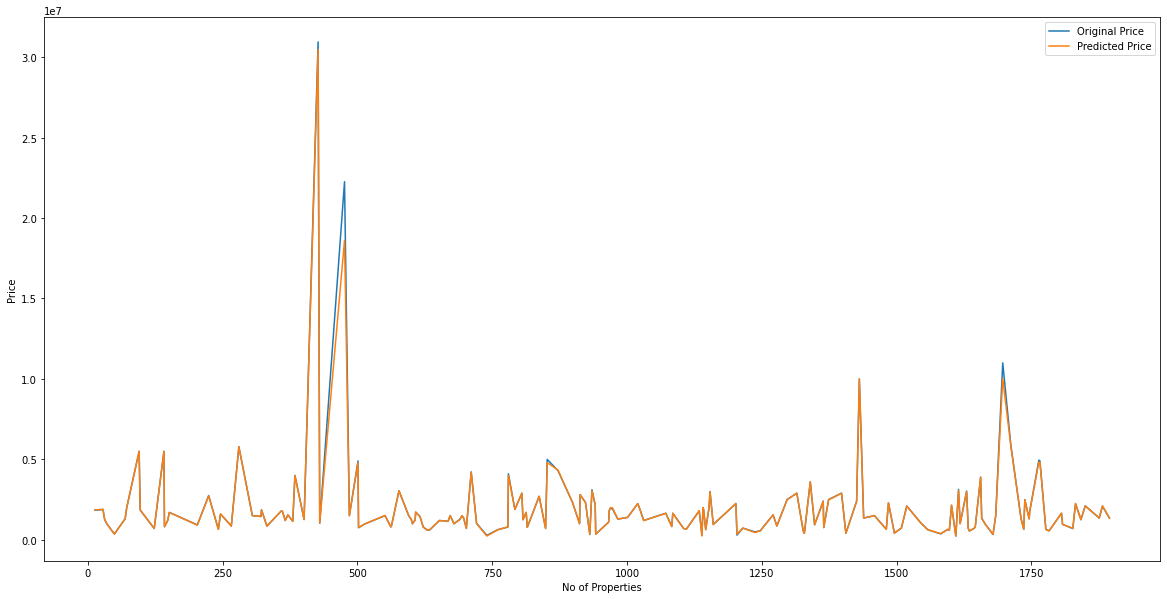

In [45]:
plt.figure(figsize=(20,10))
plt.plot(df2.price, label="Original Price")
plt.plot(df2.predicted_price, label="Predicted Price")
plt.xlabel('No of Properties')
plt.ylabel('Price')
plt.legend();